Import functions 

In [1]:
import pycbc
from pycbc import waveform, conversions, filter, types, distributions, detector
import matplotlib.pyplot as plt
import numpy as np
import mass as mass

Read the Template Bank and initialize some variables

In [2]:
class tb_params:
        def __init__(self, m1, m2, s1z, s2z, tau0, tau3, mc, q):
                self.m1 = m1
                self.m2 = m2
                self.s1z = s1z
                self.s2z = s2z
                self.tau0 = tau0
                self.tau3 = tau3
                self.mc = mc
                self.q = q

def read_tb(filename, f_min):    
    tb_file = np.loadtxt(filename)
    tb = []
    for i in range(len(tb_file)):
        temp_tau0 = conversions.pycbc.conversions.tau0_from_mass1_mass2(tb_file[i][0], tb_file[i][4], f_min)
        temp_tau3 = conversions.pycbc.conversions.tau3_from_mass1_mass2(tb_file[i][0], tb_file[i][4], f_min)
        temp_mc = conversions.mchirp_from_mass1_mass2(tb_file[i][0], tb_file[i][4])
        temp_q = tb_file[i][0]/tb_file[i][4]
        temp_obj = tb_params(tb_file[i][0], tb_file[i][4], tb_file[i][3], tb_file[i][7], temp_tau0, temp_tau3, temp_mc, temp_q)
        tb.append(temp_obj)
    return tb    

delta_f = 1/32
delta_t = 1.0/4096
f_min  = 25.0
tb = read_tb("nonspinPCA", f_min)

Generate random signal parameters using certain distributions

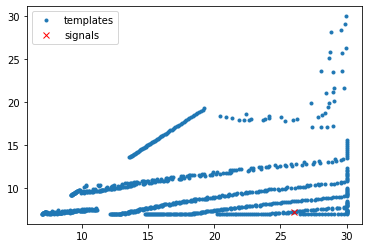

In [20]:
class sg_params:
        def __init__(self, m1, m2, s1z, s2z, tau0, tau3, dist, inc, polarization, right_asc, dec):
                self.m1 = m1
                self.m2 = m2
                self.s1z = s1z
                self.s2z = s2z
                self.tau0 = tau0
                self.tau3 = tau3
                self.dist = dist
                self.inc = inc
                self.polarization = polarization
                self.right_asc = right_asc
                self.dec = dec

def random_params_from_tb(tb, f_min, nsignal):
    tau0_min = min(x.tau0 for x in tb)
    tau0_max = max(x.tau0 for x in tb)
    tau3_min = min(x.tau3 for x in tb)
    tau3_max = max(x.tau3 for x in tb)
    mc_min = min(x.mc for x in tb)
    mc_max = max(x.mc for x in tb)
    q_min = min(x.q for x in tb)
    q_max = max(x.q for x in tb)
    #print( mc_min, mc_max, q_min, q_max)
    
    mc_distribution = mass.MchirpfromUniformMass1Mass2(mc=(mc_min, mc_max))   
    q_distribution = mass.QfromUniformMass1Mass2(q=(q_min,q_max))
        
    mc_samples = mc_distribution.rvs(size=nsignal)
    q_samples = q_distribution.rvs(size=nsignal)
    m1 = conversions.mass1_from_mchirp_q(mc_samples['mc'],q_samples['q'])
    m2 = conversions.mass2_from_mchirp_q(mc_samples['mc'],q_samples['q'])
    tau0 = conversions.tau0_from_mass1_mass2(m1 ,m2, f_min)
    tau3 = conversions.tau3_from_mass1_mass2(m1, m2, f_min)
    s1z = np.zeros(nsignal)
    s2z = np.zeros(nsignal)
    dist = 200
    inc = 0
    polarization = np.random.uniform(0, 2*np.pi, nsignal)
    right_asc = np.random.uniform(-1, 1, nsignal)
    dec = np.random.uniform(-1, 1, nsignal)
    
    sg = []
    for i in range(nsignal):
        temp_obj = sg_params(m1[i], m2[i], s1z[i], s2z[i], tau0[i], tau3[i], dist, inc, polarization[i], right_asc[i], dec[i])
        sg.append(temp_obj)
        
    tb_m1 = [x.m1 for x in tb]
    tb_m2 = [x.m2 for x in tb]
    plt.plot(tb_m1, tb_m2, '.', label='templates')
    sg_m1 = [x.m1 for x in sg]
    sg_m2 = [x.m2 for x in sg]
    plt.plot(sg_m1, sg_m2, 'x', color='red', label = 'signals')
    plt.legend()
    plt.show()
    return sg  

nsignal = 1
sg = random_params_from_tb(tb, f_min, nsignal)

Generate templates and signals using IMRPhenomD

In [21]:
def generate_template(tb, delta_f, f_min):
    hp, hc = waveform.get_fd_waveform(approximant = "IMRPhenomD",
                                      mass1 = tb.m1,
                                      mass2 = tb.m2,
                                      spin1z = tb.s1z,
                                      spin2z = tb.s2z,
                                      delta_f = delta_f,
                                      f_lower = f_min)
    return hp, hc

def generate_signal(sg, delta_t, f_min): 
    hp, hc = waveform.get_td_waveform(approximant = "IMRPhenomD",
                                      mass1 = sg.m1,
                                      mass2 = sg.m2,
                                      spin1z = sg.s1z,
                                      spin2z = sg.s2z,
                                      distance = sg.dist,
                                      inclination = sg.inc,
                                      delta_t = delta_t,
                                      f_lower = f_min)
    return hp, hc

Project signal into the detector frame

In [22]:
def signal_to_detector_frame(detector, hp_signal, hc_signal, sg):
    fx, fy = detector.antenna_pattern(sg.right_asc, sg.dec, sg.polarization, 1126259462.0)
    signal_detector = hp_signal*fx + hc_signal*fy
    return signal_detector

#plt.plot(hp_signal, '-', label='source')
#plt.plot(signal_detector, '--', label = 'detector')
#plt.legend()
#plt.show()

Compute match with the templates having a tau0 mismatch (w.r.t signal) within a tolearance  

In [38]:
def check_tau0_for_template_generation(tb, signal, tau0_threshold):
    temp_indices = []
    for i in range(len(tb)):
        if ( abs(tb[i].tau0 - signal.tau0) < tau0_threshold):
            temp_indices.append(i)
    return temp_indices

def resize_wfs(s_f, hp, hc):
    if (len(s_f) > len(hp)):
        hp.resize(len(s_f))
        hc.resize(len(s_f))
    else:
        s_f.resize(len(hp))
    return s_f, hp, hc    
        
def compute_match(sg, tb, temp_indices, delta_f, f_min):
    #Generate signal, project onto the detector frame and perform the FFT
    hp_signal, hc_signal = generate_signal(sg, delta_t, f_min)
    signal_detector = hp_signal
    #signal_detector = signal_to_detector_frame(d, hp_signal, hc_signal, sg)
    s_f = signal_detector.to_frequencyseries()
    
    match = []
    for i in range(len(temp_indices)):
        ind = temp_indices[i]
        hp_template, hc_template = generate_template(tb[ind], delta_f, f_min)
        h_f.resize(len(s_f))
        #s_f, hp, hc = resize_wfs(s_f, hp_template, hc_template)
        match.append(filter.match(hp_template, s_f, psd = None, low_frequency_cutoff = f_min)[0])
    return match    


d = detector.Detector('H1')
tau0_threshold = 30
match = []

for i in range(1):
    #Check for tau0 of templates
    temp_indices = check_tau0_for_template_generation(tb, sg[i],tau0_threshold)
    print(len(tb), len(temp_indices))
        
    hp_template, hc_template = generate_template(tb[0], delta_f, f_min)
    hp_signal, hc_signal = generate_signal(sg[0], delta_t, f_min)

    match = compute_match(sg[i], tb, temp_indices, delta_f, f_min) #Might want to take psd as an argument   
    print(max(match))
plt.plot(match, '.')
    #template = types.frequencyseries.FrequencySeries(hp, delta_f = delta_f)
    #signal = types.frequencyseries.FrequencySeries(signals[0], delta_f = delta_f)

952 952


NameError: name 'h_f' is not defined